In [141]:
import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 5]

# Inputs

## Demand

`Load` (demand) temperature-driven

<AxesSubplot:xlabel='time'>

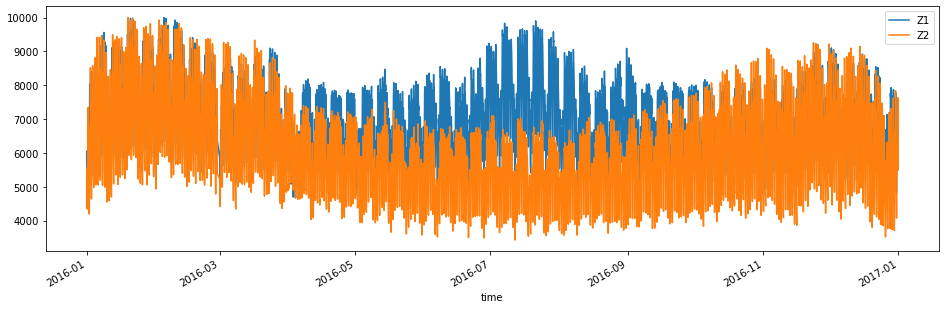

In [291]:
Z1 = pd.read_csv('data/ES_2015.csv', names=['time', 'Z1'], parse_dates=['time'], index_col = ['time'])
Z1 = Z1 / np.max(Z1) * 10000
Z2 = pd.read_csv('data/UK_2015.csv', names=['time', 'Z2'], parse_dates=['time'], index_col = ['time'])
Z2 = Z2 / np.max(Z2) * 10000
load = pd.concat([Z1, Z2], axis = 1)
load.plot()

## RES Capacity factors

In [3]:
Z1cf = pd.read_csv('data/ES_cf_2015.csv', parse_dates=['time'], index_col =['time'])[['PHOT', 'WTON', 'HROR']]
Z2cf = pd.read_csv('data/UK_cf_2015.csv', parse_dates=['time'], index_col =['time'])[['PHOT', 'WTON', 'WTOF', 'HROR']]
Z2cf.head()

,PHOT,WTON,WTOF,HROR
time,,,,
2016-01-01 00:00:00,0.0,0.663082,0.57224,0.343401
2016-01-01 01:00:00,0.0,0.647516,0.57203,0.343401
2016-01-01 02:00:00,0.0,0.626141,0.56428,0.343401
2016-01-01 03:00:00,0.0,0.603461,0.55128,0.343401
2016-01-01 04:00:00,0.0,0.584645,0.54259,0.343401


## Thermal profiles (not used)

In [4]:
Z1tf = pd.DataFrame({'time': Z1.index, 'Z1': 1.0}).set_index(['time'])
Z2tf = pd.DataFrame({'time': Z2.index, 'Z1': 1.0}).set_index(['time'])

## Inflow (not used)

In [292]:
Z1 = pd.read_csv('data/ES_inflow_2015.csv', parse_dates=['time'], index_col = ['time'])


# Set up model

In [324]:
network = pypsa.Network()
network.set_snapshots(range(8760))
## BUS --------------------------------
network.add('Bus', 'Z1')
network.add('Bus', 'Z2')
## GENERATORS -------------------------

network.add('Generator', 'Z1-Fossil', bus = 'Z1',
            p_nom = 9000, marginal_cost = 50, p_min_pu = 0.05, ramp_limit_up = 0.15, ramp_limit_down = 0.15)
network.add('Generator', 'Z1-Wind Onshore', bus = 'Z1',
            p_nom = 5000, marginal_cost = 0,
            p_max_pu = pd.Series(Z1cf['WTON'].values) )
network.add('Generator', 'Z1-Solar', bus = 'Z1',
            p_nom = 15000, marginal_cost = 0,
            p_max_pu = pd.Series(Z1cf['PHOT'].values))

network.add('Generator', 'Z2-Fossil', bus = 'Z2',
            p_nom = 9000, marginal_cost = 50, p_min_pu = 0.05, ramp_limit_up = 0.15, ramp_limit_down = 0.15)
network.add('Generator', 'Z2-Wind Onshore', bus = 'Z2',
            p_nom = 15000, marginal_cost = 0,
            p_max_pu = pd.Series(Z2cf['WTON'].values))
network.add('Generator', 'Z2-Solar', bus = 'Z2',
            p_nom = 5000, marginal_cost = 0,
            p_max_pu = pd.Series(Z2cf['PHOT'].values))

network.add("StorageUnit","Z1-pumping", bus='Z1',
        p_nom=1000,
        max_hours=12 #energy storage in terms of hours at full power
       )
network.add("StorageUnit", "Z2-pumping", bus='Z2',
        p_nom=1000,
        max_hours=12)

network.add("Load",'Z1 load',bus='Z1',
            p_set=pd.Series(load['Z1'].values))
network.add("Load", 'Z2 load', bus='Z2',
            p_set=pd.Series(load['Z2'].values))

network.add("Link",
            'Z1-Z2',
            bus0='Z1',
            bus1='Z2',
            efficiency = 0.99,
            p_nom=3000,
            p_min_pu=-1)

In [325]:
network.lopf(solver_name='cbc', pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.28s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.14e+09


('ok', 'optimal')

In [326]:
all_dis = pd.concat([network.generators_t.p, network.storage_units_t.p], axis = 1)
z1dis = all_dis[[col for col in all_dis if col.startswith('Z1')]]
z2dis = all_dis[[col for col in all_dis if col.startswith('Z2')]]
all_dis.head()

,Z1-Fossil,Z1-Wind Onshore,Z1-Solar,Z2-Fossil,Z2-Wind Onshore,Z2-Solar,Z1-pumping,Z2-pumping
0,1808.40620,1238.10,0.0,450.0,8062.7749,0.0,0.0,0.0
1,1444.23630,1193.70,0.0,450.0,7987.3038,0.0,0.0,0.0
2,1143.37610,1135.45,0.0,450.0,7598.7146,0.0,0.0,0.0
3,954.13307,1071.30,0.0,450.0,7246.1997,0.0,0.0,0.0
4,974.05873,962.30,0.0,450.0,6947.4797,0.0,0.0,0.0


(0.0, 15000.0)

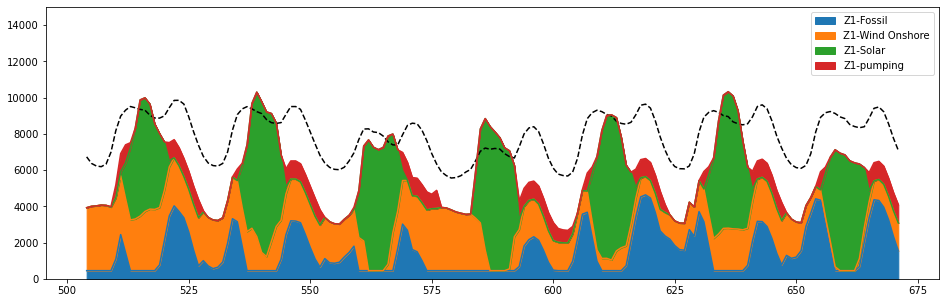

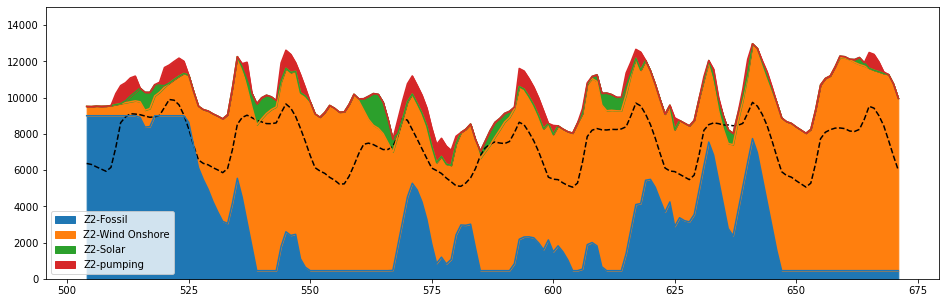

In [337]:
WEEK_TO_PLOT = 3
NSTEP = range(WEEK_TO_PLOT*7*24, (WEEK_TO_PLOT+1)*7*24)
fig, ax = plt.subplots()
load.reset_index().iloc[NSTEP].Z1.plot(ax = ax, color = 'black', style = '--')
z1dis.iloc[NSTEP].clip(lower = 0).plot.area(ax = ax)
ax.set_ylim([0,15000])

fig2, ax2 = plt.subplots()
load.reset_index().iloc[NSTEP].Z2.plot(ax = ax2, color = 'black', style = '--')
z2dis.iloc[NSTEP].clip(lower = 0).plot.area(ax = ax2)
ax2.set_ylim([0,15000])

In [328]:
network.objective/1e9

2.137350097747866

<AxesSubplot:>

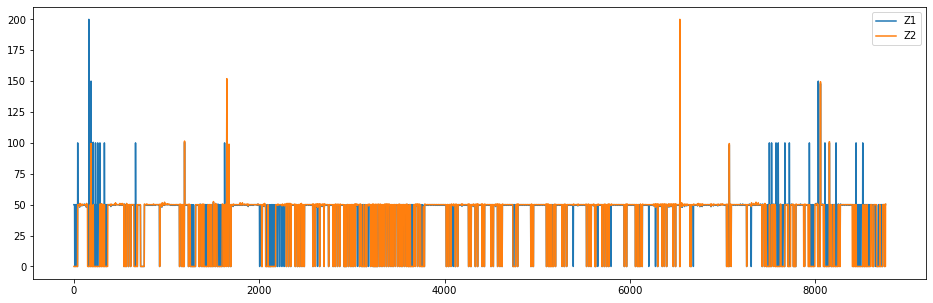

In [329]:
network.buses_t.marginal_price.plot()


<AxesSubplot:>

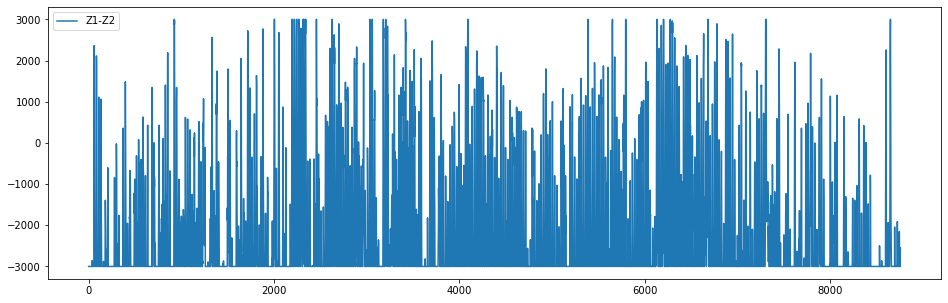

In [330]:
network.links_t.p0.plot()

In [331]:
available = network.generators_t.p_max_pu.multiply(network.generators.p_nom_opt).sum()
used = network.generators_t.p.sum()
curtailment = (available-used)/available
curtailment

Z1-Fossil              -inf
Z1-Solar           0.081437
Z1-Wind Onshore    0.112044
Z2-Fossil              -inf
Z2-Solar           0.091804
Z2-Wind Onshore    0.048684
dtype: float64

In [332]:
(network.generators_t.p.multiply(network.buses_t.marginal_price['Z1'],axis=0).sum()/network.generators_t.p.sum())

Z1-Fossil          47.843110
Z1-Wind Onshore    45.525659
Z1-Solar           31.473643
Z2-Fossil          48.979638
Z2-Wind Onshore    37.940601
Z2-Solar           32.663604
dtype: float64

In [333]:
(network.generators_t.p.multiply(network.buses_t.marginal_price['Z2'],axis=0).sum()/network.generators_t.p.sum())

Z1-Fossil          40.137419
Z1-Wind Onshore    41.076276
Z1-Solar           32.281121
Z2-Fossil          48.513775
Z2-Wind Onshore    27.094218
Z2-Solar           33.976310
dtype: float64

In [341]:
#CO2 emissions